In [34]:
import os
import time
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, root_mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error

In [5]:
# import sprf package
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest

### Read contents of AEGISDataset

In [30]:
# Read the CSV file into a DataFrame
df = pd.read_csv('../aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')
df = df.drop(columns=['Unnamed: 0', 'geometry', 'flood_height'], errors='ignore')

In [31]:
# Display the first few rows of the DataFrame
print("Data Head:")
df.head()

Data Head:


,lat,lon,flood_height,elevation,precipitation,is_flooding,geometry,hazard_level
0,14.640394,121.055708,0,54.553295,9.0,0,POINT (121.0557085 14.64039374),0.0
1,14.698299,121.002132,0,21.856272,10.0,0,POINT (121.0021322 14.69829935),0.0
2,14.698858,121.100261,0,69.322807,16.0,0,POINT (121.1002614 14.69885841),0.0
3,14.571310,120.983334,0,10.987241,8.0,0,POINT (120.9833345 14.57131006),0.0
4,14.762232,121.075735,0,87.889847,18.0,0,POINT (121.0757349 14.7622323),0.0


In [32]:
# Display information on about the DataFrame
print("\nData Info:")
print(df.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            3511 non-null   float64
 1   lon            3511 non-null   float64
 2   flood_height   3511 non-null   int64  
 3   elevation      3511 non-null   float64
 4   precipitation  3511 non-null   float64
 5   is_flooding    3511 non-null   int64  
 6   geometry       3511 non-null   object 
 7   hazard_level   3511 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 219.6+ KB
None


### Simulate Spatial Random Forest Regression Model (sklearn)

In [22]:
# Specify columns: Adjust these based on your dataset's actual column names
spatial_features = ['lat', 'lon']  # Spatial features
target_column = 'is_flooding'      # Binary target column (flood or no flood)
predictor_columns = [col for col in df.columns if col not in [target_column, 'lat', 'lon']]

# Prepare feature matrix (X) and target vector (y)
X = df[spatial_features + predictor_columns].values
y = df[target_column].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Normalize the data (optional for non-tree models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Initialize and Train Models

# Random Forest Classifier for binary flood prediction
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Decision Tree Regressor (optional, if you have continuous flood intensity data)
# dt_model = DecisionTreeRegressor(random_state=42)
# dt_model.fit(X_train, y_train)

# Logistic Regression as an additional baseline model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Step 4: Evaluate Models on Test Data

# Random Forest Predictions and Evaluation
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

# Logistic Regression Predictions and Evaluation
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_confusion = confusion_matrix(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Confusion Matrix:\n", lr_confusion)

# Decision Tree Regression (only if continuous data is available)
# dt_predictions = dt_model.predict(X_test)
# dt_mse = mean_squared_error(y_test, dt_predictions)
# print("Decision Tree Regression MSE:", dt_mse)

Random Forest Classifier Accuracy: 0.7041251778093883
Random Forest Confusion Matrix:
 [[121 148]
 [ 60 374]]
Logistic Regression Accuracy: 0.647226173541963
Logistic Regression Confusion Matrix:
 [[ 29 240]
 [  8 426]]


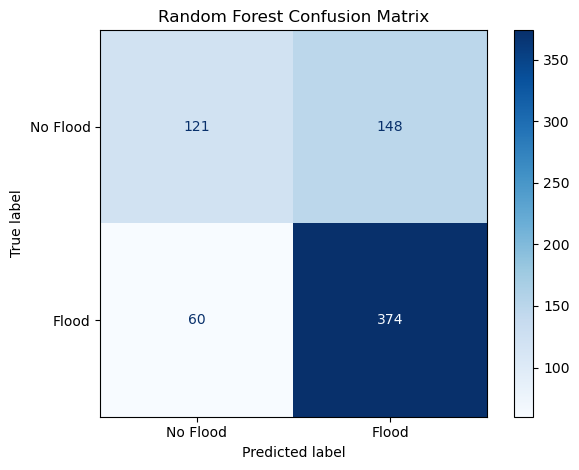

In [23]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

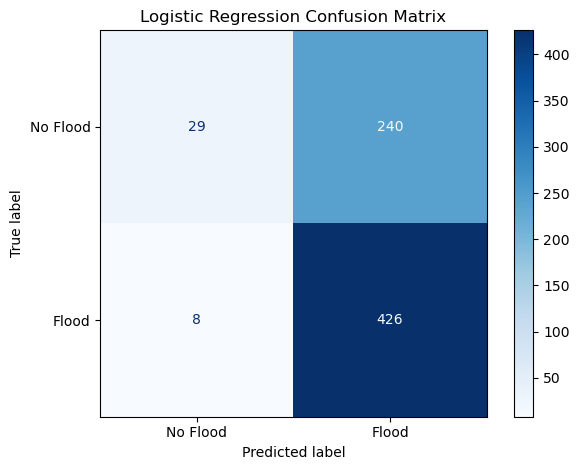

In [24]:
ConfusionMatrixDisplay(lr_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

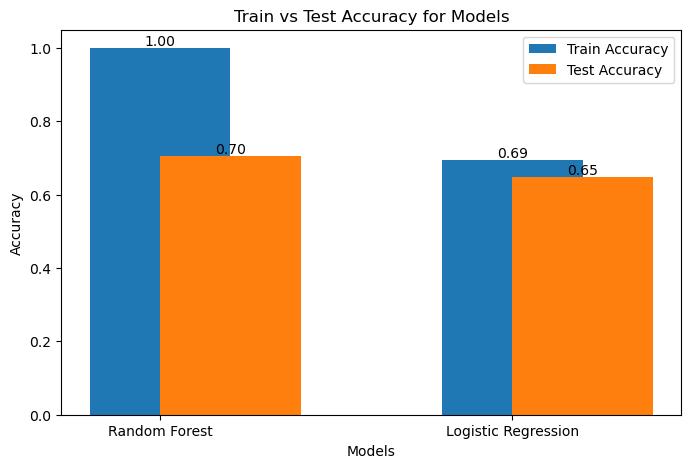

In [25]:
# Compute train accuracy for each model
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train))
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train))

# List of model names and their corresponding train/test accuracies
models = ['Random Forest', 'Logistic Regression']
train_accuracies = [rf_train_accuracy, lr_train_accuracy]
test_accuracies = [rf_accuracy, lr_accuracy]

# Plotting
x = range(len(models))  # Model indices

fig, ax = plt.subplots(figsize=(8, 5))
train_bars = ax.bar(x, train_accuracies, width=0.4, label='Train Accuracy', align='center')
test_bars = ax.bar(x, test_accuracies, width=0.4, label='Test Accuracy', align='edge')

# Labeling each bar with its accuracy value
for bar in train_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom'
    )

for bar in test_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom'
    )

# Labeling axes and title
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
ax.set_title("Train vs Test Accuracy for Models")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

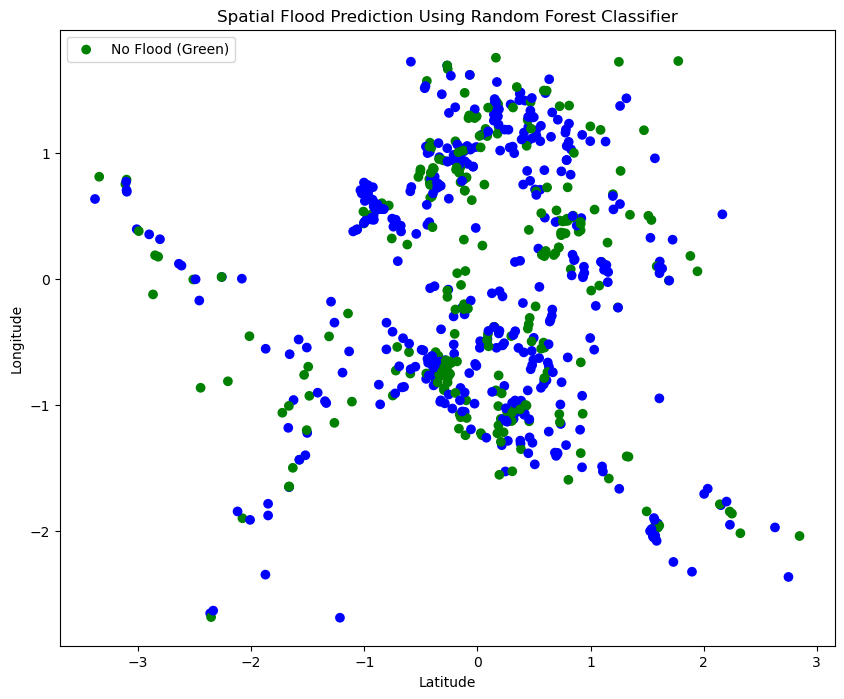

In [7]:
# Step 5: Visualize Spatial Predictions from Random Forest Model
# Assuming latitude and longitude are the first two columns in X_test
plt.figure(figsize=(10, 8))
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, marker='o', label='Predicted Flood')
# plt.colorbar(label='Flood Prediction')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Random Forest Classifier')
plt.legend(['No Flood (Green)'])
plt.show()

That wasn't good... Let's try to optimize the hyperparameters.

### Simulate Spatial Random Forest Regression Model (sklearn) with optimization(?)

In [ ]:
# Specify columns
spatial_features = ['lat', 'lon']
target_column = 'is_flooding'
predictor_columns = [col for col in df.columns if col not in [target_column, 'lat', 'lon']]

# Prepare feature matrix (X) and target vector (y)
X = df[spatial_features + predictor_columns].values
y = df[target_column].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
import optuna
# Step 1: Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Initialize the model with these hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the model and evaluate it on the validation set
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions, squared=False)
    return rmse

# Step 2: Set up Optuna study with TPE sampler
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="maximize", sampler=sampler)
study = optuna.create_study(direction="minimize")

# Step 3: Run the optimization with a specified number of trials
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2024-11-11 02:01:53,901] A new study created in memory with name: no-name-bc672096-dad6-4509-8604-5c54463636b2
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 02:01:54,454] Trial 0 finished with value: 0.5594144469629286 and parameters: {'n_estimators': 122, 'max_depth': 44, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5594144469629286.
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 02:01:56,409] Trial 1 finished with value: 0.5491490896080536 and parameters: {'n_estimators': 196,

Best Hyperparameters: {'n_estimators': 206, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best RMSE: 0.5360410166680325


In [34]:
# refit model
# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate on the test set
predictions = best_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Optimized RMSE: {rmse:.2f} minutes')

Optimized RMSE: 0.54 minutes


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
rf_accuracy = accuracy_score(y_test, predictions)
rf_confusion = confusion_matrix(y_test, predictions)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

Random Forest Classifier Accuracy: 0.7041251778093883
Random Forest Confusion Matrix:
 [[113 156]
 [ 52 382]]


In [36]:
# Feature Importance
feature_importances = best_model.feature_importances_
feature_names = spatial_features + predictor_columns
sorted_indices = np.argsort(feature_importances)[::-1]

print("Feature Importance Ranking:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

Feature Importance Ranking:
lat: 0.3178
elevation: 0.2960
lon: 0.2877
precipitation: 0.0508
hazard_level: 0.0476


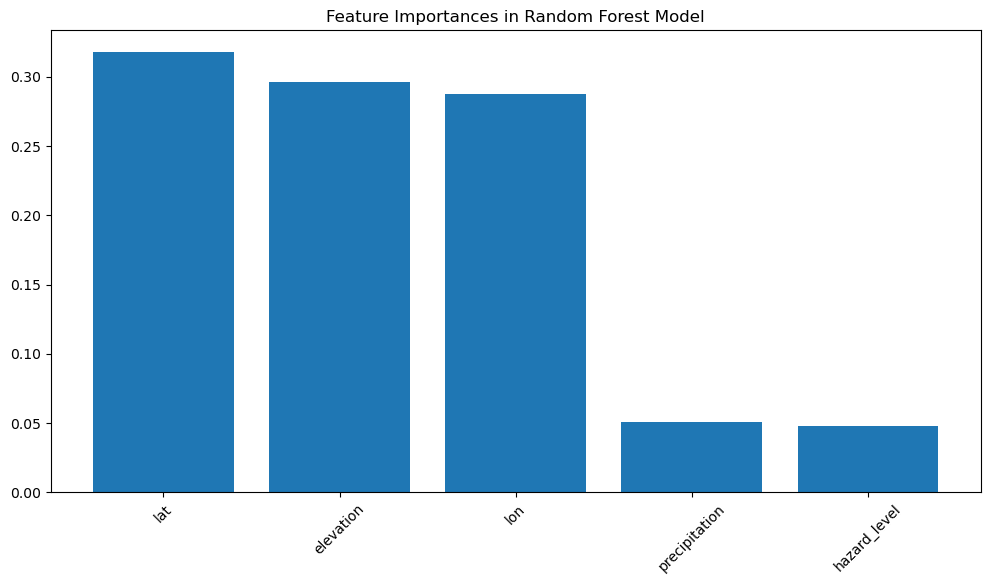

In [37]:
# Visualization of Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=45)
plt.title("Feature Importances in Random Forest Model")
plt.show()

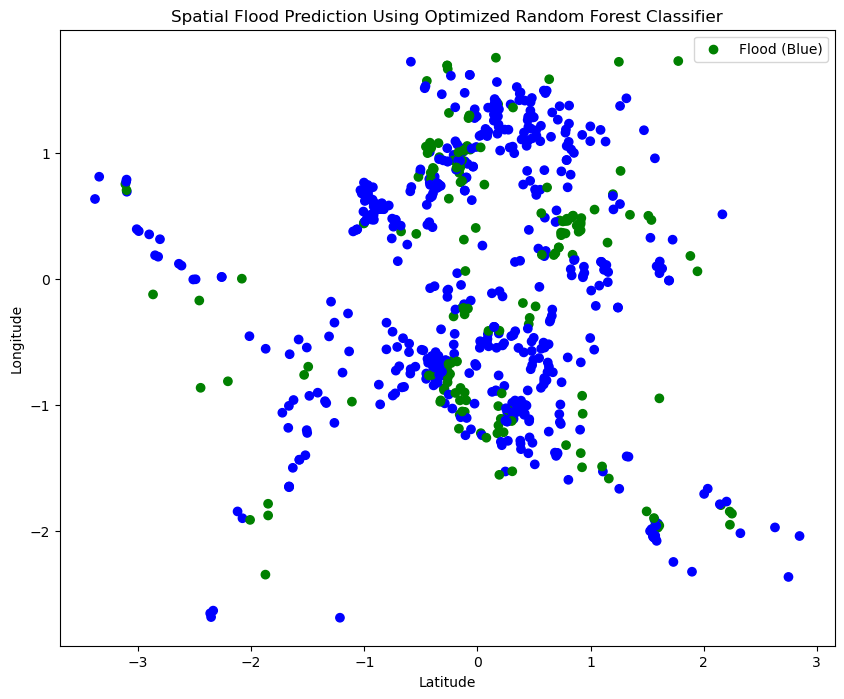

In [38]:
# Visualization of Spatial Predictions
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.figure(figsize=(10, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, marker='o', label='Predicted Flood')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Optimized Random Forest Classifier')
plt.legend(['Flood (Blue)', 'No Flood (Green)'])
plt.show()

# Conclusion

### Sprf module

In [36]:
# Standard and GIS Modules
import os
import numpy as np
import pandas as pd
import time
import scipy
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# import sprf package
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest

### Load Data

In [37]:
# Load the AEGISDataset_SJOIN_merged_cleaned.csv dataset
data = pd.read_csv('../aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')
print("Data loaded with shape:", data.shape)

# bypass unnecessary columns
data = data.drop(columns=['Unnamed: 0', 'geometry', 'flood_height'], errors='ignore')

# Define target variable and coordinates for the AEGIS dataset
target = 'is_flooding'  # Update if using a different target column
lon = 'lon'             # Replace with the actual longitude column name in your dataset
lat = 'lat'             # Replace with the actual latitude column name in your dataset

Data loaded with shape: (3511, 9)


### Split into Train and Test

In [38]:
# Splitting into train and test sets
def prepare_data(data, target, lon=lon, lat=lat):
    """Assumes all columns except lon, lat, and target are covariates."""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [39]:
# Random split
inds = np.random.permutation(len(data))
split = int(0.9 * len(data))
train_data = data.iloc[inds[:split]]
test_data = data.iloc[inds[split:]]

# Prepare train and test sets
train_x, train_y, train_coords = prepare_data(train_data, target)
test_x, test_y, test_coords = prepare_data(test_data, target)

In [40]:
# Lists to track accuracy
train_accuracies = []
test_accuracies = []

In [41]:
# Ensure data is binary
print("Unique values in train_y:", np.unique(train_y))
print("Unique values in test_y:", np.unique(test_y))

Unique values in train_y: [0 1]
Unique values in test_y: [0 1]


### Train and test basic random forest

In [42]:
n_estimators = 100
max_depth = 10
spatial_neighbors = len(data) // 5  # Adjust as needed

In [43]:
# Train and test basic Random Forest
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
rf.fit(train_x, train_y)
# test_pred = rf.predict(test_x)
train_accuracies.append(accuracy_score(train_y, rf.predict(train_x)))
test_accuracies.append(accuracy_score(test_y, rf.predict(test_x)))
rf_cm = confusion_matrix(test_y, rf.predict(test_x))

# rmse_rf = mean_squared_error(test_pred, test_y, squared=False)
# print("Error of basic Random Forest: ", rmse_rf)

# # Confusion Matrix for Random Forest
# ConfusionMatrixDisplay(rf_cm).plot()
# plt.title("Random Forest Confusion Matrix")
# plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
ConfusionMatrixDisplay(rf_cm, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

### Train and test spatial random forest

In [16]:
# Train and test Spatial Random Forest
sp = SpatialRandomForest(max_depth=max_depth, neighbors=spatial_neighbors)
sp.fit(train_x, train_y, train_coords)
test_pred = sp.predict(test_x, test_coords)

rmse_spatial_rf = mean_squared_error(test_pred, test_y, squared=False)
print("Error of spatial Random Forest: ", rmse_spatial_rf)

Error of spatial Random Forest:  0.4592249451064349


C:\Users\Jed Padro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Train and test geographical random forest

In [17]:
# Train and test Geographical Random Forest
geo_rf = GeographicalRandomForest(n_estimators=n_estimators, neighbors=spatial_neighbors, max_depth=max_depth)
geo_rf.fit(train_x, train_y, train_coords)
test_pred = geo_rf.predict(test_x, test_coords)

rmse_geo_rf = mean_squared_error(test_pred, test_y, squared=False)
print("Error of Geographical Random Forest: ", rmse_geo_rf)

Error of Geographical Random Forest:  0.45506904017748584


C:\Users\Jed Padro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Tune number of neighbors

In [18]:
# Tune number of neighbors
tuned_sp_rf = SpatialRandomForest(n_estimators=n_estimators, neighbors=500, max_depth=max_depth)
tuned_sp_rf.tune_neighbors(train_x, train_y, train_coords)
print("Tuned spatial rf neighbors:", tuned_sp_rf.neighbors)

# Train tuned Spatial Random Forest
tuned_sp_rf.fit(train_x, train_y, train_coords)
test_pred = tuned_sp_rf.predict(test_x, test_coords)

rmse_spatial_rf_tuned = mean_squared_error(test_pred, test_y, squared=False)
print("Error of tuned spatial Random Forest: ", rmse_spatial_rf_tuned)


Tuned spatial rf neighbors: 2871
Error of tuned spatial Random Forest:  0.46711570107825406


C:\Users\Jed Padro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
